# __<u>Initialize Cloud-AI Engine</u>__ 
> with a developed and distinct environment: __py39==ens3 (Python 3.9.16)__
>> you can use --> cmd Run: __conda install -n py39==ens3 ipykernel --update-deps --force-reinstall__

> Install/Verify Packages

In [3]:
# %pip install --user --upgrade pandas
# %pip install --user --upgrade "sqlalchemy<2.0"
# %pip install --user --upgrade mariadb
# %pip install --user --upgrade -U matplotlib
# %pip install --user --upgrade seaborn
# %pip install --user -U scikit-learn

> Import Libraries

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from   keras.layers import Dense
from   tensorflow.keras import layers
import gym
from   collections import deque
import seaborn as sns
import random
from datetime import time


# __Configure Simulation Setup__

> Define directory of Processed Data

In [15]:
loadDirectory = '../Data/ProcessedData/'

>Define directory of Trained Models

In [16]:
# Create a directory to save the models
model_save_dir = "saved_models_v1.1"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

> Define colunmns and rows of pandas output

In [17]:
# pd.set_option('display.max_columns', 50)
# pd.set_option('display.max_rows', 50000)

> Work on GPU utilization
>> 1. https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
>> 2. https://www.tensorflow.org/guide/gpu#using_multiple_gpus
>> 3. https://www.tensorflow.org/guide/gpu#using_a_single_gpu_on_a_multi-gpu_system

In [18]:
### Limiting GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
print('Available Physical GPUs=>'+str(gpus))
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print('Configured Logical GPUs=>'+str(logical_gpus))
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Available Physical GPUs=>[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Configured Logical GPUs=>[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


> Define GPU which will be used

In [19]:
# Set the GPU you want to use
selectGPU = 1
os.environ["CUDA_VISIBLE_DEVICES"] = str(selectGPU)
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    selectedGPU = f"/device:GPU:{selectGPU}"
    print(f"Using GPU: {selectedGPU}")

### Clearing Tensorflow Session
tf.keras.backend.clear_session()

Using GPU: /device:GPU:1


# __<u>PV Data Processing for Model Development and Testing</u>__

> __<u> Load Pre-processed Power Plants data for each PV power plant </u>__
>> Note from ENS: 
>>   * Power_Plant 3, C_pcode __71780001~71780003__ : Seomyeon, Gyeongju-si, Gyeongsangbuk-do

In [20]:
PV1 = pd.read_csv(f"{loadDirectory}PV_71780001.gzip", compression="gzip")
PV2 = pd.read_csv(f"{loadDirectory}PV_71780002.gzip", compression="gzip") 
PV3 = pd.read_csv(f"{loadDirectory}PV_71780004.gzip", compression="gzip")

> <b>Dropped</b> unnecessary data, <b>renamed</b> column and <b>set index</b> with timestamp

In [21]:
PV1 = PV1.drop(columns={'day_power'}).rename(columns={'inst_power':'pv1_power'}).set_index('timestamp')
PV2 = PV2.drop(columns={'day_power'}).rename(columns={'inst_power':'pv2_power'}).set_index('timestamp')
PV3 = PV3.drop(columns={'day_power'}).rename(columns={'inst_power':'pv3_power'}).set_index('timestamp')

>Combine above dataFrames to <b>raw_data</b> according to the index and <b>calculated total power</b>

In [22]:
raw_data = PV1.join(PV2).join(PV3)
raw_data = raw_data.fillna(0)
# calculate the total power output and add it as a new column
raw_data['total_power'] = raw_data.sum(axis=1)
raw_data=raw_data.reset_index()
# Convert the 'timestamp' column to a pandas datetime object
raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])
raw_data ['timestamp'][0]

Timestamp('2020-11-10 18:20:00')

In [23]:
raw_data

,timestamp,pv1_power,pv2_power,pv3_power,total_power
0,2020-11-10 18:20:00,0.0,0.0,0.0,0.0
1,2020-11-10 18:21:00,0.0,0.0,0.0,0.0
2,2020-11-10 18:22:00,0.0,0.0,0.0,0.0
3,2020-11-10 18:23:00,0.0,0.0,0.0,0.0
4,2020-11-10 18:24:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...
1205491,2023-03-16 08:57:00,47.4,35.1,24.3,106.8
1205492,2023-03-16 08:58:00,51.7,40.6,27.0,119.3
1205493,2023-03-16 08:59:00,44.3,48.6,32.6,125.5
1205494,2023-03-16 09:00:00,50.8,54.0,28.0,132.8


In [24]:
# def calculate_hourly_data(data):
#     data['timestamp'] = pd.to_datetime(data['timestamp'])
#     data.set_index('timestamp', inplace=True)
#     hourly_data = data.resample('H').sum()
#     hourly_data=hourly_data.reset_index()
#     hourly_data['timestamp'] = pd.to_datetime(hourly_data['timestamp'])
#     hourly_data.fillna(0, inplace=True) # Fill null values with zero
#     return hourly_data

In [25]:
class GridDemandGenerator:
    def __init__(self, max_demand):
        self.max_demand = max_demand
    
    def generate_daily_grid_demand(self, timestamp):
        t = timestamp.time()
        if time(22, 0) <= t or t < time(6, 0):
            return 0.25 # 25%
        elif time(6, 0) <= t < time(14, 0):
            return 0.5  # 50%
        elif time(14, 0) <= t < time(18, 0):
            return 0.75 # 75%
        elif time(18, 0) <= t < time(22, 0):
            return 1.0 # 100%
    
    def adjust_seasonal_grid_demand(self, row):
        timestamp = pd.to_datetime(row['timestamp'])
        month = timestamp.month
        grid_demand = self.max_demand * self.generate_daily_grid_demand(timestamp)
        if month in [1, 2, 12]:
            adjustment = random.uniform(0.20, 0.25)
        elif month in [6, 7, 8, 9]:
            adjustment = random.uniform(0.10, 0.20)
        elif month in [3, 4, 5]:
            adjustment = random.uniform(-0.05, 0.10)
        elif month in [10, 11]:
            adjustment = random.uniform(-0.05, 0.15)
        else:
            adjustment = 0
        adjusted_demand = grid_demand * (1 + adjustment)
        return round(adjusted_demand, 1)
    
    def get_grid_demand(self, df):
        df['timestamp']   = pd.to_datetime(df['timestamp'])
        df['grid_demand'] = df.apply(self.adjust_seasonal_grid_demand, axis=1)
        df.fillna(0, inplace=True)
        return df

In [26]:
new_data = GridDemandGenerator(max_demand=200).get_grid_demand(raw_data)
new_data

,timestamp,pv1_power,pv2_power,pv3_power,total_power,grid_demand
0,2020-11-10 18:20:00,0.0,0.0,0.0,0.0,192.0
1,2020-11-10 18:21:00,0.0,0.0,0.0,0.0,212.0
2,2020-11-10 18:22:00,0.0,0.0,0.0,0.0,212.0
3,2020-11-10 18:23:00,0.0,0.0,0.0,0.0,190.9
4,2020-11-10 18:24:00,0.0,0.0,0.0,0.0,220.5
...,...,...,...,...,...,...
1205491,2023-03-16 08:57:00,47.4,35.1,24.3,106.8,109.3
1205492,2023-03-16 08:58:00,51.7,40.6,27.0,119.3,102.6
1205493,2023-03-16 08:59:00,44.3,48.6,32.6,125.5,95.1
1205494,2023-03-16 09:00:00,50.8,54.0,28.0,132.8,106.8


>Plot each column of <b>plot_data</b> against the timestamp

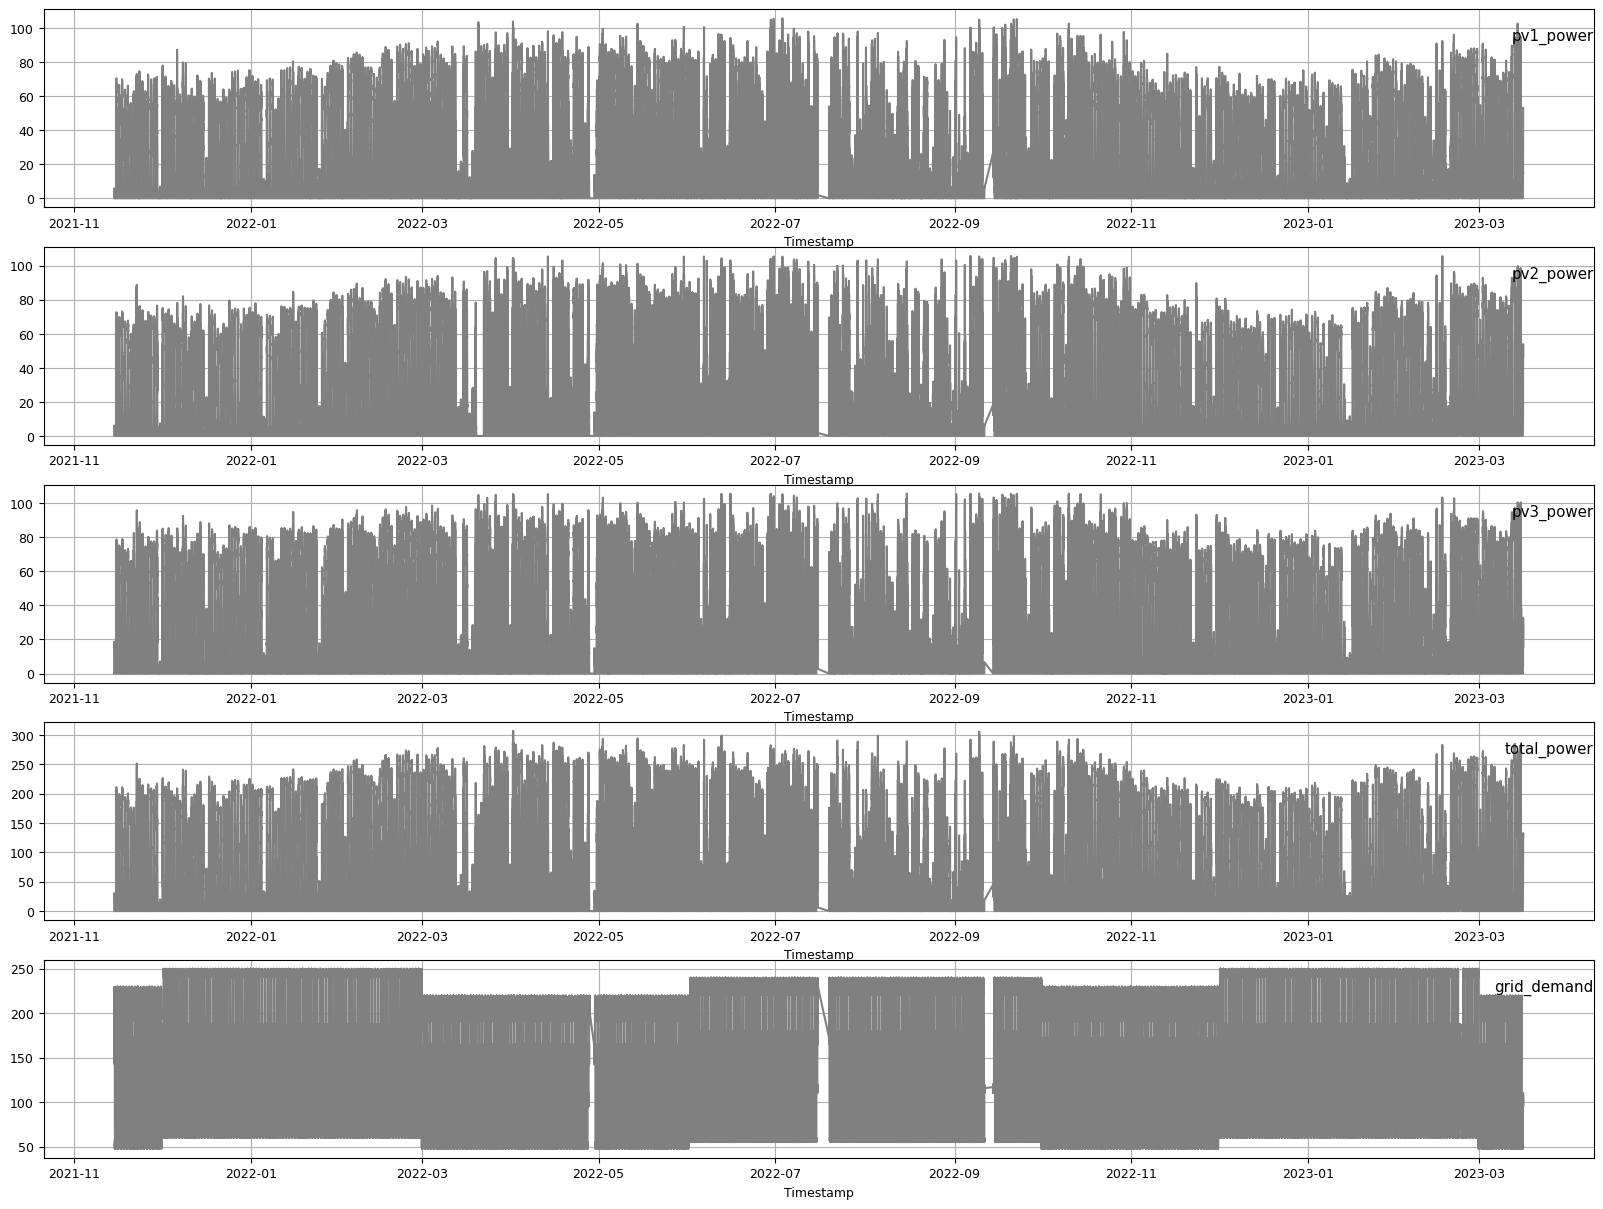

In [27]:
# plot_data = raw_data[60*24*15:]
plot_data = new_data[60*24*30*12:]
# plot_data = completed_data[24*30*20:]
i    = 1
plt.figure(figsize=(20, 18))
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['font.size'] = '9'
for counter in range(1,len(plot_data.columns)):
    plt.subplot(len(plot_data.columns), 1, i)
    plt.plot(plot_data.values[:, 0], plot_data.values[:, counter], color = 'gray')
    # plt.plot(plot_data.values[:, counter], color = 'gray')
    plt.title(plot_data.columns[counter], y=0.8, loc='right')
    plt.xlabel('Timestamp')
    plt.ylabel('')
    plt.grid(True)
    i = i+1
plt.show()

> <b>Segment data</b> into windows of specified length and stride

In [34]:
# input features
data = plot_data.drop(columns=['timestamp'])
# Convert plot_data to data_np as np array
data_np = np.array(data)
# Replacing 0 with 0.01
# data_np[data_np == 0] = 0.01
print(data_np)

# Define window length and stride for segmenting data
window_length  = 60*24*7   # Length of the window (number of data points per segment)
stride         = 60*24*5   # Number of data points to move the window after each episode
train_percent  = 0.95      # 95%
# Assuming pv1_power, pv2_power, and pv3_power are the column indices for the respective columns
pv1_power	 = 0
pv2_power	 = 1
pv3_power	 = 2
net_power    = 3
grid_demand  = 4  

# Initialize an empty list to store the segmented data
data_index       = 0
data_np_segments = []
for episode_start in range(0, len(data_np), stride):
    episode_end = episode_start + window_length
    print(f'data_index={data_index} | episode_start={episode_start} | episode_end={episode_end}\x00')
    # Slice the train_data array to get the specified columns for the current segment
    data_segment = data_np[episode_start:episode_end, [pv1_power, pv2_power, pv3_power, net_power, grid_demand]]
    # Append the segment to the list
    data_np_segments.append(data_segment)
    data_index += 1

num_total_episodes = data_index-1
num_train_episodes = int(num_total_episodes*train_percent)
num_test_episodes  = num_total_episodes-num_train_episodes

print(f'\nnum_train_episodes={num_train_episodes} | num_test_episodes={num_test_episodes}\x00')

[[  5.6   6.   18.6  30.2 164.1]
 [  4.9   6.1  17.   28.  147.7]
 [  4.9   6.   17.   27.9 155.7]
 ...
 [ 44.3  48.6  32.6 125.5  95.1]
 [ 50.8  54.   28.  132.8 106.8]
 [ 53.1  46.7  28.3 128.1 104.4]]
data_index=0 | episode_start=0 | episode_end=10080 
data_index=1 | episode_start=7200 | episode_end=17280 
data_index=2 | episode_start=14400 | episode_end=24480 
data_index=3 | episode_start=21600 | episode_end=31680 
data_index=4 | episode_start=28800 | episode_end=38880 
data_index=5 | episode_start=36000 | episode_end=46080 
data_index=6 | episode_start=43200 | episode_end=53280 
data_index=7 | episode_start=50400 | episode_end=60480 
data_index=8 | episode_start=57600 | episode_end=67680 
data_index=9 | episode_start=64800 | episode_end=74880 
data_index=10 | episode_start=72000 | episode_end=82080 
data_index=11 | episode_start=79200 | episode_end=89280 
data_index=12 | episode_start=86400 | episode_end=96480 
data_index=13 | episode_start=93600 | episode_end=103680 
data_index=1

> Test Point

In [29]:
data_np_segments[2]

array([[  4.7,   4.8,  19.2,  28.7, 169. ],
       [  4.7,   4.6,  18.1,  27.4, 164.4],
       [  4.9,   4.6,  18.7,  28.2, 150.1],
       ...,
       [  3.1,   3.2,  24.2,  30.5, 182.8],
       [  2.9,   3.1,  23.8,  29.8, 180.4],
       [  2.9,   3.1,  23. ,  29. , 184.6]])

In [30]:
data_np_segments[2][:3,4]

array([169. , 164.4, 150.1])

In [35]:
np.max(data_np_segments[2][:,3])

226.6

In [36]:
np.max(data_np_segments[2][:,4])

230.0

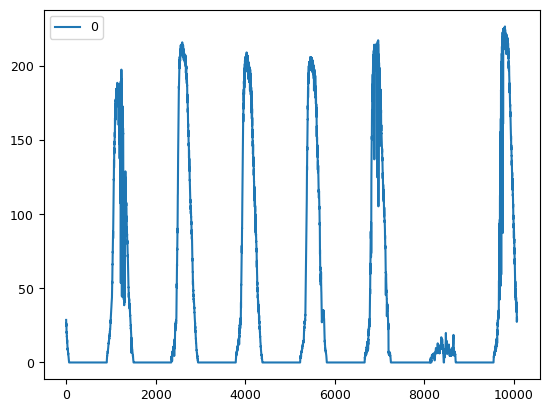

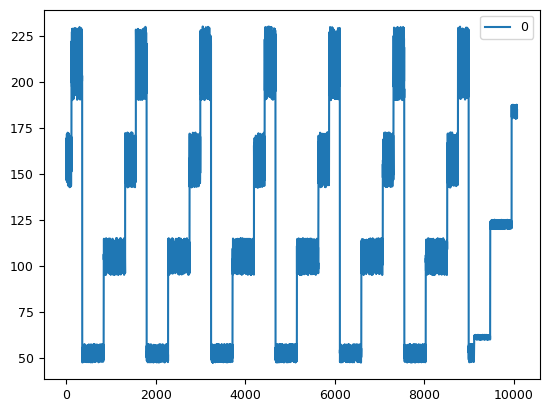

In [31]:
# print(data_np_segments[1])
pd.DataFrame(data_np_segments[2][:,3]).plot()
pd.DataFrame(data_np_segments[2][:,4]).plot()
plt.show()

# __<u>Advanced DDPG for Enhanced SSLM in ESS and Solar Integrated VPP</u>__
- Deep Deterministic Policy Gradient (DDPG) 
- Safety and Sustainable Lifecycle Management (SSLM)
- Energy Storage System (ESS)
- Virtual Power Plant (VPP)

In [21]:
class DDPG:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, tau):
        self.state_dim        = state_dim
        self.action_dim       = action_dim
        self.lr_actor         = lr_actor
        self.lr_critic        = lr_critic
        self.gamma            = gamma
        self.tau              = tau
        self.actor            = self.build_actor()
        self.target_actor     = self.build_actor()
        self.critic           = self.build_critic()
        self.target_critic    = self.build_critic()
        self.actor_optimizer  = tf.keras.optimizers.Adam(lr_actor)
        self.critic_optimizer = tf.keras.optimizers.Adam(lr_critic)

    def build_actor(self):
        model = tf.keras.Sequential([
            Dense(128, activation='relu', input_shape=(self.state_dim,)),
            Dense(128, activation='relu'),
            Dense(64,  activation='relu'),
            Dense(self.action_dim, activation='tanh')
        ])
        return model
    
    def build_critic(self):
        state_input  = tf.keras.Input(shape=(self.state_dim,))
        action_input = tf.keras.Input(shape=(self.action_dim,))
        state_net    = Dense(128, activation='relu')(state_input)
        state_net    = Dense(64,  activation='relu')(state_net)
        action_net   = Dense(64,  activation='relu')(action_input)
        net          = tf.keras.layers.Concatenate()([state_net, action_net])
        net          = Dense(64,  activation='relu')(net)
        net          = Dense(32,  activation='relu')(net)
        net          = Dense(1)(net)
        model        = tf.keras.Model(inputs=[state_input, action_input], outputs=net)
        return model
    
    def update_target_networks(self):
        actor_weights         = self.actor.get_weights()
        target_actor_weights  = self.target_actor.get_weights()
        critic_weights        = self.critic.get_weights()
        target_critic_weights = self.target_critic.get_weights()
        for i in range(len(actor_weights)):
            target_actor_weights[i]  = self.tau * actor_weights[i]  + (1 - self.tau) * target_actor_weights[i]
        for i in range(len(critic_weights)):
            target_critic_weights[i] = self.tau * critic_weights[i] + (1 - self.tau) * target_critic_weights[i]
        self.target_actor.set_weights(target_actor_weights)
        self.target_critic.set_weights(target_critic_weights)

    def train(self, replay_buffer, batch_size):
        with tf.device(selectedGPU):  # Adding this line to ensure operations are performed on the specified GPU
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            # Update critic
            target_actions = self.target_actor(next_states)
            target_q_values = self.target_critic([next_states, target_actions])
            target_q_values = tf.stop_gradient(rewards + (1 - dones) * self.gamma * target_q_values)
            with tf.GradientTape() as tape:
                q_values = self.critic([states, actions])
                critic_loss = tf.reduce_mean(tf.square(target_q_values - q_values))
            critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
            self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))
            # Update actor
            with tf.GradientTape() as tape:
                actions = self.actor(states)
                actor_loss = -tf.reduce_mean(self.critic([states, actions]))
            actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
            self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))
            # Update target networks
            self.update_target_networks()

    def load_weights(self, actor_weights_path, critic_weights_path):
        self.actor.load_weights(actor_weights_path)
        self.critic.load_weights(critic_weights_path)


class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        try:
            return [np.array(x) for x in zip(*batch)]
        except ValueError as e:
            print("Error: ", e)
            print("Samples causing the issue:")
            for sample in batch:
                print(sample)
            raise

    def __len__(self):
        return len(self.buffer)
    


class VPPEnvironment(gym.Env):
    def __init__(self, solar_power, grid_demand, ess_capacity, ess_charging_efficiency, ess_discharging_efficiency, ess_operation_time):
        super(VPPEnvironment, self).__init__()
        self.solar_power                = solar_power
        self.grid_demand                = grid_demand
        self.max_ess                    = ess_capacity               # 20x100kWH ESS Battery
        self.ess_charging_efficiency    = ess_charging_efficiency    # 0.85
        self.ess_discharging_efficiency = ess_discharging_efficiency # 0.95
        self.ess_operation_time         = ess_operation_time         # 1/60
        self.action_dim                 = 3                          # Charging/Discharging/Isolation of ESS
        self.state_dim                  = 3                          # Scaled Solar_Power, Grid_Demand, ESS_Utilization 
        self.cur_step                   = 0
        self.cur_ess                    = 0
        self.cur_solar_power            = 0
        self.cur_grid_demand            = 0
        self.action_space               = gym.spaces.Box(low=-1, high=1, shape=(self.action_dim,), dtype=np.float32)
        self.observation_space          = gym.spaces.Box(low= 0, high=1, shape=(self.state_dim,),  dtype=np.float32)
        self.max_solar_power            = np.max(self.solar_power)
        self.max_grid_demand            = np.max(self.grid_demand)
        

    def reset(self):
        self.cur_step                   = 0
        self.cur_ess                    = 0
        return self._get_observation()
    

    def _get_observation(self):
        scaled_cur_solar_power          = round(self.cur_solar_power/self.max_solar_power, 4)
        scaled_cur_grid_demand          = round(self.cur_grid_demand/self.max_grid_demand, 4)
        scaled_cur_ess                  = round(self.cur_ess/ self.max_ess, 4)     
        scaled_state_values             = np.array([scaled_cur_solar_power, scaled_cur_grid_demand, scaled_cur_ess])
        # print(f'scaled_state_values={scaled_state_values}')
        return scaled_state_values

    def step(self, action):
        clipped_action                  = np.clip(action, self.action_space.low, self.action_space.high)
        self.cur_solar_power            = self.solar_power[self.cur_step]
        self.cur_grid_demand            = self.grid_demand[self.cur_step]
        ess_discharge_amount            = 0
        ess_charge_amount               = 0
        reward                          = 0
        action_type                     = 'System Started'
        normal_operation                = 0
        abnormal_operation              = 0

        # Agent's actions
        # ESS should be charged until it is full during extra power generation
        if clipped_action[0] > clipped_action[1] and clipped_action[0] > clipped_action[2]:
            ess_discharge_amount            = 0
            if self.cur_solar_power > self.cur_grid_demand and self.cur_ess < self.max_ess * self.ess_charging_efficiency:
                action_type             = "Charging[OK]"
                ess_charge_amount       = min((self.cur_solar_power - self.cur_grid_demand) * self.ess_charging_efficiency * self.ess_operation_time, self.max_ess * self.ess_charging_efficiency - self.cur_ess)
                self.cur_ess           += ess_charge_amount
            else:
                action_type             = "Charging[NA]"
        # ESS should be discharged unless it is almost empty during less power generation
        elif clipped_action[1] > clipped_action[0] and clipped_action[1] > clipped_action[2]:
            ess_charge_amount              = 0
            if self.cur_solar_power < self.cur_grid_demand and self.cur_ess > 1* self.ess_discharging_efficiency:
                action_type            = "Discharging[OK]"
                ess_discharge_amount   = max(self.cur_ess, 1)* self.ess_discharging_efficiency * self.ess_operation_time
                self.cur_ess          -= ess_discharge_amount
            else:
                action_type            = "Discharging[NA]"
        # ESS should be isolated when it is full and power generation meets demand
        elif clipped_action[2] > clipped_action[0] and clipped_action[2] > clipped_action[1]:
            ess_charge_amount          = 0
            ess_discharge_amount       = 0
            if self.power > self.demand and self.ess >= self.ess_max:
                action_type            = "Isolated[OK]"
            else:
                action_type            = "Isolated[NA]"

        # Assign rewards for agent's action
        if "OK" in action_type:
            reward                     =  1
            normal_operation           =  1
        elif "NA" in action_type:
            reward                     = -1
            abnormal_operation         =  1
        else:
            reward                     =  0
        # # Demand deviation should be minimized gradually
        self.demand_deviation          = abs(self.cur_solar_power + self.cur_ess - self.cur_grid_demand)
        # # reward                        -= self.demand_deviation
        # reward                        -= 3 if self.demand_deviation > 0 else reward

        # Moving to next step of operation
        self.cur_step                 += 1
        
        # Checking whether to stop the execution
        done = self.cur_step >= len(self.solar_power) - 1

        info = {
            'current_step'           : self.cur_step, 
            'current_pv_power'       : self.cur_solar_power, 
            'current_demand'         : self.cur_grid_demand,
            'current_action'         : action_type, 
            'current_ess'            : self.cur_ess,
            'demand_deviation'       : self.demand_deviation,
            'normal_operation'       : normal_operation,
            'abnormal_operation'     : abnormal_operation,
            'action_value'           : clipped_action,
        }
        return self._get_observation(), reward, done, info

In [22]:
def plot_rewards_and_deviations(episode_rewards, demand_deviations, saving_name, model_save_dir=model_save_dir):
    episodes = range(1, len(episode_rewards) + 1)
    # Set a style and color palette
    sns.set(style="whitegrid")
    color_palette = sns.color_palette("deep")
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(episodes, episode_rewards, linestyle='-', linewidth=2, marker='o', markersize=3, color=color_palette[0], markerfacecolor='w', markeredgewidth=1.5)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward")
    plt.title("Episode Rewards")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.subplot(2, 1, 2)
    plt.plot(episodes, demand_deviations, linestyle='-', linewidth=2, marker='s', markersize=3, color=color_palette[2], markerfacecolor='w', markeredgewidth=1.5)
    plt.xlabel("Episode")
    plt.ylabel("Demand Deviation")
    plt.title("Episode Demand Deviations")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    # Save the plot as a file
    plot_path = os.path.join(model_save_dir, saving_name+'.png')
    plt.savefig(plot_path)
    # Show the plot
    plt.show()

def evaluate_saved_models(model_save_dir, num_train_episodes, num_test_episodes, max_steps_per_episode):
    model_files = os.listdir(model_save_dir)
    def custom_sort(file_name):
        episode_number = int(file_name.split('_')[2].split('.')[0])
        return episode_number

    sorted_actor_files = sorted([file for file in model_files if 'actor' in file], key=custom_sort)
    sorted_critic_files = sorted([file for file in model_files if 'critic' in file], key=custom_sort)

    paired_files = list(zip(sorted_actor_files, sorted_critic_files))

    # Assuming the column names are 'pv1_power', 'pv2_power', and 'pv3_power'
    column_names = ['pv1_power', 'pv2_power', 'pv3_power']
    # Convert the NumPy array in train_data_np_segments to a pandas DataFrame
    test_segment = pd.DataFrame(data_np_segments[num_train_episodes+1], columns=column_names)
    # Create Test Environment
    env   = VPPEnvironment(test_segment)
    # Evaluate the saved models
    agent = DDPG(state_dim=env.state_dim, action_dim=env.action_dim, lr_actor=0.001, lr_critic=0.002, gamma=0.99, tau=0.005)

    test_episode_rewards = []
    test_episode_deviations = []

    for actor_model_file, critic_model_file in paired_files:
        actor_weights_path = os.path.join(model_save_dir, actor_model_file)
        critic_weights_path = os.path.join(model_save_dir, critic_model_file)
        agent.load_weights(actor_weights_path, critic_weights_path)

        total_reward = []
        total_deviation = []
        
        for test_episode in range(num_train_episodes+1, num_train_episodes+num_test_episodes, 1):

            test_segment    = pd.DataFrame(data_np_segments[test_episode], columns=column_names)
            env             = VPPEnvironment(test_segment)

            state              = env.reset()
            episode_reward     = 0
            episode_deviation  = []
            done               = False
            step_counter       = 0

            while not done:
                step_counter += 1
                action = agent.actor(np.expand_dims(state, axis=0)).numpy()[0]
                next_state, reward, done, info = env.step(action)

                state = next_state
                episode_reward += reward
                episode_deviation.append(info['demand_deviation'])
                
                if step_counter >= max_steps_per_episode:
                    break
                
                print(f"Episode={test_episode+1} | Count_Steps={info['current_step']} | Demand_Deviation={np.mean(episode_deviation):.2f} | Accumulated_Rewards={episode_reward:.2f} \x00", end='\r')

            total_reward.append(episode_reward)
            total_deviation.append(episode_deviation)

        avg_reward             = np.mean(total_reward)
        avg_deviation          = np.mean(total_deviation)
        test_episode_rewards.append(avg_reward)
        test_episode_deviations.append(avg_deviation)

        print(f"Model {actor_model_file} and {critic_model_file}: Average Reward = {avg_reward:.2f} | Average Demand Gap = {avg_deviation:.2f}\x00")

    # Plot the evaluation results
    plot_rewards_and_deviations(test_episode_rewards, test_episode_deviations, 'evaluating_trained_models')

In [29]:
def main():
    with tf.device(selectedGPU):  # Add this line to ensure operations are performed on the specified GPU
        # Initialize Parameters
        num_saving_models = 10
        batch_size        = 1
        warm_up           = 1000
        train_episodes    = num_train_episodes
        max_steps         = window_length
        saving_interval   = int(num_train_episodes/num_saving_models)
        solar_power       = data_np_segments[0][:,3]
        grid_demand       = data_np_segments[0][:,4]
        ess_capacity  
        total_steps       = 0
        episode_rewards   = []

        demand_deviations = []
        episode_c         = []
        episode_c_na      = []
        episode_d         = []
        episode_d_na      = []
        
        # Initialize DDPG System
        env               = VPPEnvironment(train_segment)
        agent             = DDPG(state_dim=env.state_dim, action_dim=env.action_dim, lr_actor=0.001, lr_critic=0.002, gamma=0.99, tau=0.005)
        replay_buffer     = ReplayBuffer(max_size=100000)
        
        # Training Loop per Episode
        for episode in range(train_episodes):
            train_segment             = data_np_segments[episode][:,3]
            env                       = VPPEnvironment(train_segment)
            state                     = env.reset()
            episode_reward            = 0
            cumulative_deviation      = 0
            charging_count            = 0
            discharging_count         = 0
            charging_count_na         = 0
            discharging_count_na      = 0

            # Training Loop per Episode
            for step in range(max_steps):
                action = agent.actor(np.expand_dims(state, axis=0)).numpy()[0]
                next_state, reward, done, info = env.step(action)
                replay_buffer.store(state, action, float(reward), next_state, done)

                state                 = next_state
                episode_reward       += reward
                current_step          = info['current_step']
                current_pv_power      = info['current_pv_power']
                current_demand        = info['current_demand']
                current_action        = info['current_action']
                current_ess           = info['current_ess']
                cumulative_deviation += info['demand_deviation']
                charging_count       += info['charging_count']
                discharging_count    += info['discharging_count']
                action_value          = info['action_value']
                charging_count_na    += info['charging_count_na']
                discharging_count_na += info['discharging_count_na']
                total_steps          += 1
                
                print(f'Episode={episode+1} << Step={current_step} | ESS_Action={current_action} | A={action_value} | C={charging_count} | D={discharging_count} | CX={charging_count_na} | DX={discharging_count_na} | ESS_Value={current_ess:.2f} | PV_Power={current_pv_power:.2f} | Demand={current_demand:.2f} | Demand_Gap={cumulative_deviation/current_step:.2f} | Cumulative_Rewards={episode_reward:.2f} \x00', end='\r')
   
                if total_steps > warm_up and len(replay_buffer) >= batch_size:
                    agent.train(replay_buffer, batch_size)

                if done:
                    break

            episode_c.append(charging_count)
            episode_c_na.append(charging_count_na)
            episode_d.append(discharging_count)
            episode_d_na.append(discharging_count_na)
            episode_rewards.append(episode_reward)
            demand_deviations.append(cumulative_deviation/current_step)

            print(f'Episode={episode+1} << Step={current_step} | ESS_Action={current_action} | A={action_value} | C={charging_count} | D={discharging_count} | CX={charging_count_na} | DX={discharging_count_na} | ESS_Value={current_ess:.2f} | PV_Power={current_pv_power:.2f} | Demand={current_demand:.2f} | Demand_Gap={cumulative_deviation/current_step:.2f} | Cumulative_Rewards={episode_reward:.2f} \x00')

            if (episode+1) % saving_interval == 0 or (episode+1 == train_episodes):
                actor_save_path  = os.path.join(model_save_dir,  f"actor_episode_{episode + 1}.h5")
                critic_save_path = os.path.join(model_save_dir, f"critic_episode_{episode + 1}.h5")
                agent.actor.save_weights(actor_save_path)
                agent.critic.save_weights(critic_save_path)
                print(f"Actor model saved in {actor_save_path}")
                print(f"Critic model saved in {critic_save_path}")

        # Return episode_rewards and demand_deviations
        return episode_rewards, demand_deviations, episode_c, episode_c_na, episode_d, episode_d_na

In [30]:
if __name__ == '__main__':
    rewards, deviations, c, c_na, d, d_na = main()

Episode=1 << Step=719 | ESS_Action=Isolated | A=[-0.0183984  -0.08382184  0.05582187] | C=1 | D=0 | CX=0 | DX=0 | ESS_Value=1700.00 | PV_Power=5656.40 | Demand=3293.09 | Demand_Gap=3653.38 | Cumulative_Rewards=-3589.00   00  
Actor model saved in saved_models_v7.7\actor_episode_1.h5
Critic model saved in saved_models_v7.7\critic_episode_1.h5
Episode=2 << Step=719 | ESS_Action=Discharging[NA] | A=[-0.1547859   0.99829084 -0.5177518 ] | C=0 | D=0 | CX=0 | DX=434 | ESS_Value=0.00 | PV_Power=3275.00 | Demand=4017.03 | Demand_Gap=4212.65 | Cumulative_Rewards=-3159.00   
Actor model saved in saved_models_v7.7\actor_episode_2.h5
Critic model saved in saved_models_v7.7\critic_episode_2.h5
Episode=3 << Step=719 | ESS_Action=Discharging[NA] | A=[-0.04561197  0.45202997 -0.5545056 ] | C=0 | D=0 | CX=0 | DX=719 | ESS_Value=0.00 | PV_Power=4108.50 | Demand=3890.45 | Demand_Gap=4317.65 | Cumulative_Rewards=-2876.00   52.00  
Actor model saved in saved_models_v7.7\actor_episode_3.h5
Critic model save

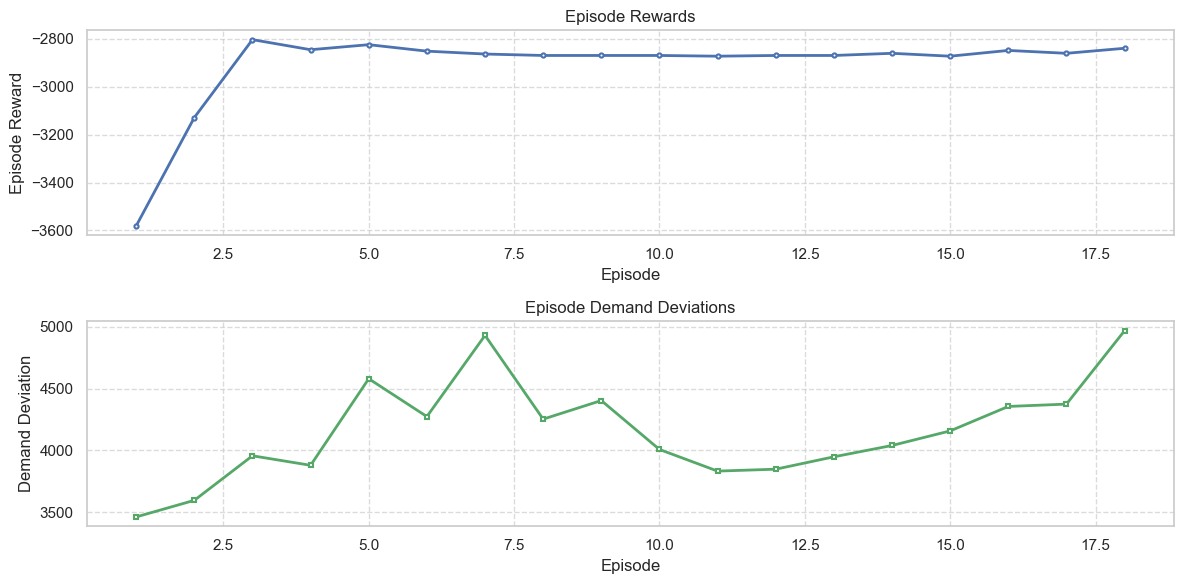

In [ ]:
plot_rewards_and_deviations(rewards, deviations, 'rewards_and_deviations_during_train')

In [ ]:
evaluate_saved_models(model_save_dir, num_train_episodes, num_test_episodes, 10)

ValueError: Shape of passed values is (208, 4), indices imply (208, 3)